In [1]:

import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd
import pickle 
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)
phbond = []
def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)
    for i in bond_triplets_print:
        phbond.append(i)
    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return np.array(phbond)

def tica(data, lagtime, var_cutoff):
    '''RETURNS: projected data on tics, tica object
    '''
    est = TICA(lagtime=lagtime, var_cutoff = var_cutoff).fit(data)
    tica = est.fetch_model()
    plt.scatter(np.arange(20),tica.singular_values[:20])
    plt.xticks(np.arange(20),np.arange(20))
    plt.title("Eigen Values")
    return tica.transform(data), tica
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers
def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)

def load_dict(file):
    with open(file,"rb") as handle:
        dic_loaded = pickle.load(handle)
    return dic_loaded
def save_dict(file, dict):
    with open(file, "wb") as handle:
        pickle.dump(dict, handle)
    return None

In [4]:
#outdir = '/Users/achakrab/Documents/asn/tica'
pdb = '/home/apara/asn/biorxiv2021-6626290-no-water-glue/lig47.pdb'
rep0 = '/home/apara/asn/biorxiv2021-6626290-no-water-glue/ligand_47_1.xtc'
#helixpdb = './Trajectory_Files_12.20.21/R2R3_all_helix.pdb'
#apodir = './Trajectory_Files_12.20.21/R2_R3_APO/'

In [5]:
trj = md.load(rep0, top=pdb)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames

In [6]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)


residue_offset = 121
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)


** SYSTEM INFO **

Number of atoms: 338

Number of residues: 21

Number of protein residues: 20

Number of frames: 1100889

Starting frame: 0

Last frame: 1100889

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140, ASP121, <1>1]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA', 'ASP', '<1>']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]



In [19]:
#hbonds = md.baker_hubbard(trj, periodic=False)
#label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
#for hbond in hbonds:
#    print(label(hbond))

In [7]:
# Definie Hydrogen Bond Donors in EPI-002
lig_hbond_donors = [[329, 331], [329, 330]]
hbonds = print_donors_acceptors(
    trj[0], angle_cutoff=150, distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)

nh_donors [(0, 8), (12, 20), (19, 24), (19, 25), (26, 35), (41, 46), (51, 63), (72, 81), (87, 95), (118, 124), (129, 138), (144, 153), (159, 163), (166, 178), (187, 196), (195, 202), (195, 203), (204, 212), (216, 228), (237, 246), (266, 275), (281, 287)]
ASP121-N ASP121-H
ASN122-N ASN122-H
ASN122-ND2 ASN122-HD21
ASN122-ND2 ASN122-HD22
GLU123-N GLU123-H
ALA124-N ALA124-H
TYR125-N TYR125-H
GLU126-N GLU126-H
MET127-N MET127-H
SER129-N SER129-H
GLU130-N GLU130-H
GLU131-N GLU131-H
GLY132-N GLY132-H
TYR133-N TYR133-H
GLN134-N GLN134-H
GLN134-NE2 GLN134-HE21
GLN134-NE2 GLN134-HE22
ASP135-N ASP135-H
TYR136-N TYR136-H
GLU137-N GLU137-H
GLU139-N GLU139-H
ALA140-N ALA140-H
oh_donors [(62, 71), (123, 128), (177, 186), (227, 236)]
TYR125-OH TYR125-HH
SER129-OG SER129-HG
TYR133-OH TYR133-HH
TYR136-OH TYR136-HH
sh_donors []
<1>1-N <1>1-H
<1>1-N <1>1-H
acceptors
ASP121-N
ASP121-O
ASP121-OD1
ASP121-OD2
ASN122-N
ASN122-O
ASN122-OD1
ASN122-ND2
GLU123-N
GLU123-O
GLU123-OE1
GLU123-OE2
ALA124-N
ALA124-O
TYR

In [8]:
hbonds.shape

(2016, 3)

In [8]:
res = list(dict.fromkeys([str(trj.topology.residue(i)) for i in range(22)]))

In [9]:
[top.residue(i) for i in range(trj.n_residues)]

[ASP121,
 ASN122,
 GLU123,
 ALA124,
 TYR125,
 GLU126,
 MET127,
 PRO128,
 SER129,
 GLU130,
 GLU131,
 GLY132,
 TYR133,
 GLN134,
 ASP135,
 TYR136,
 GLU137,
 PRO138,
 GLU139,
 ALA140,
 ASP121,
 <1>1]

In [10]:
hbonds_inter_idx = ~np.array(list(map(lambda x:all(x<294)|all(x>293), hbonds)))
hbonds_inter = hbonds[hbonds_inter_idx]
hbonds_inter_sort_idx = np.argsort(hbonds_inter[:,0])
hbonds_inter_sorted = hbonds_inter[hbonds_inter_sort_idx]
res_atoms = [top.select(f"resid {i}") for i in range(trj.n_residues)]

res_atoms[0] = np.concatenate([res_atoms[0],res_atoms[-2]])
res_atoms.pop(-2) #don't run pop twice as it is an inplace list operation
res_atoms_dict = dict(zip(res,res_atoms))
res_hbonds_dict = {i:{"atoms":hbonds_inter_sorted[np.isin(hbonds_inter_sorted[:,0],res_atoms_dict[i])],
                       "distances":None} for i in res_atoms_dict.keys()}
for i in res:
    res_hbonds_dict[i]["distances"] = md.compute_distances(trj,res_hbonds_dict[i]["atoms"][:,[0,2]],
                                    periodic=False)

    

In [16]:
res_hbonds_dict['ASP121']['distances']

array([[1.165, 1.250, 0.964, ..., 0.850, 0.928, 0.950],
       [1.349, 1.428, 1.076, ..., 0.945, 1.059, 1.083],
       [1.344, 1.393, 1.043, ..., 0.951, 0.952, 0.893],
       ...,
       [3.695, 3.537, 3.085, ..., 2.969, 3.043, 2.755],
       [3.490, 3.294, 2.903, ..., 2.934, 2.746, 2.520],
       [3.823, 3.756, 3.547, ..., 3.598, 3.383, 3.134]], dtype=float32)

In [25]:
hbond=[]
for key in res_hbonds_dict:
    hbond.append(res_hbonds_dict[key]['distances'])
    
hbond_=np.column_stack(hbond)

In [27]:
hbond_.shape

(1100889, 314)

In [163]:
save_dict('lig47_hbonds_dict', res_hbonds_dict)

In [74]:
res_names = [trj.topology.atom(i).residue for i in np.array(hbond_new)[:,0]]

In [21]:
dist_1.shape

(1100889, 326)

In [37]:
dist_3.shape

(1988,)

In [4]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

In [4]:
dmat = np.load("/home/apara/Documents/asn/tica/fusadil/hbond/distance_hbond_matrix.npy")
dmat.shape

(1110889, 1988)

In [87]:
dmat[:100]

array([[2.747, 4.194, 2.720, ..., 5.079, 5.289, 6.874],
       [2.998, 4.174, 2.667, ..., 4.662, 5.357, 6.127],
       [3.244, 4.255, 2.918, ..., 4.881, 5.305, 6.410],
       ...,
       [2.693, 4.209, 2.658, ..., 5.207, 5.341, 6.851],
       [2.703, 4.303, 2.804, ..., 5.012, 5.516, 6.350],
       [2.784, 4.000, 2.730, ..., 4.809, 5.370, 6.749]], dtype=float32)

In [25]:
features = np.hstack((dmat, hbonds_f))
features.shape

(111089, 2008)

In [26]:
np.save("distance_inter_hbond_matrix.npy", dist)

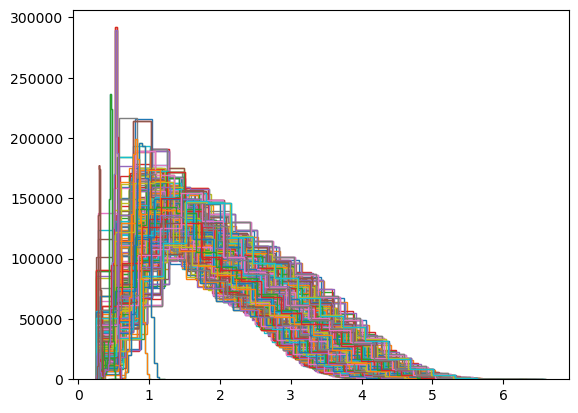

In [29]:
for i in range(0,326):
   plt.hist((dist[:,i]),histtype='step',bins=20,label=i) 

<Figure size 640x480 with 0 Axes>

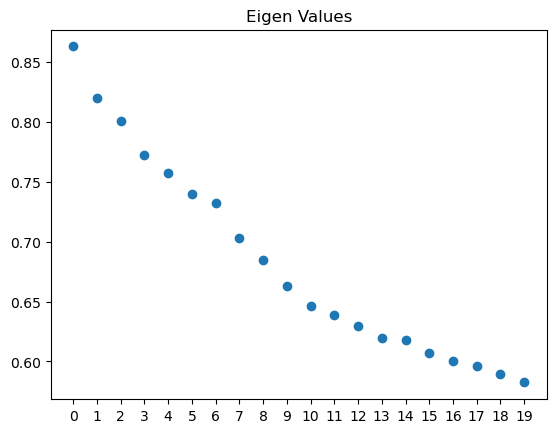

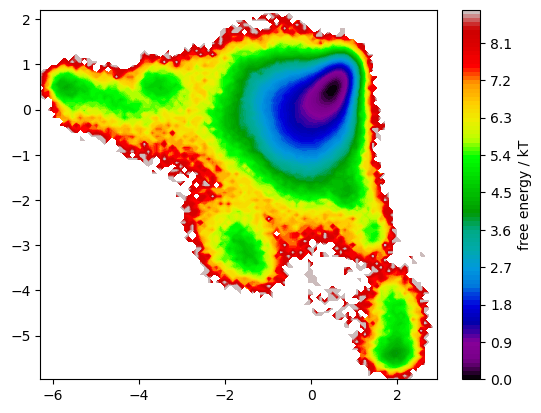

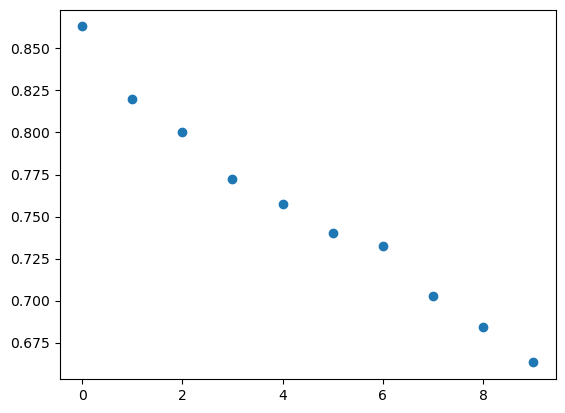

<Figure size 640x480 with 0 Axes>

In [92]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 10
##|
combined = dist
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()

<BarContainer object of 4 artists>

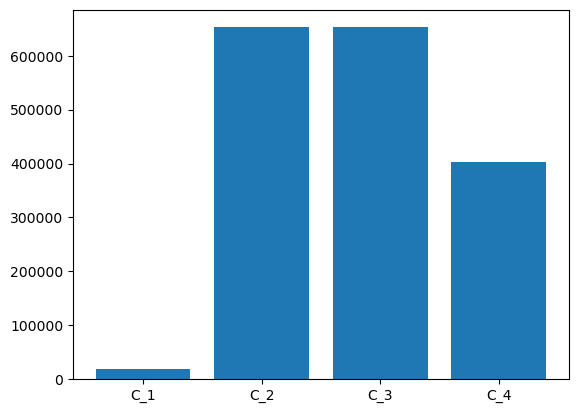

In [93]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

c0 = c0_i.size
c1 = c1_i.size
c2 = c1_i.size
c3 = c3_i.size
size = [c0, c1, c2, c3]
langs = ['C_1', 'C_2', 'C_3', 'C_4']
plt.bar(langs, size)

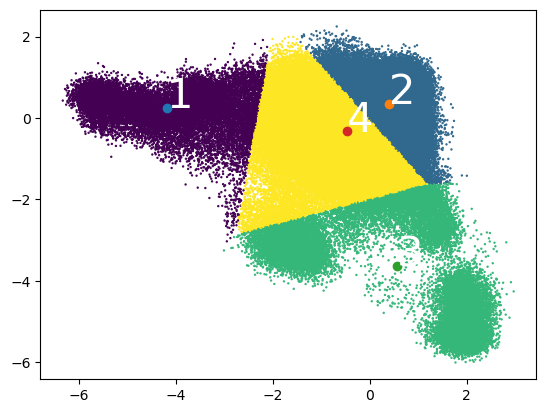

In [94]:
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
for j,i in enumerate(clustercenters):
    plt.annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
    
plt.scatter(clustercenters[0,0], clustercenters[0,1])
plt.scatter(clustercenters[1,0], clustercenters[1,1])
plt.scatter(clustercenters[2,0], clustercenters[2,1])
plt.scatter(clustercenters[3,0], clustercenters[3,1])

In [95]:
np.save('fasudil_inter_hbond_tica_combined_10.npy', tica_combined)
np.save('fasudil_inter_hbond_proj_combined_10.npy', proj_combined)
np.save('fasudil_inter_hbond_combined_10.npy', dtraj)

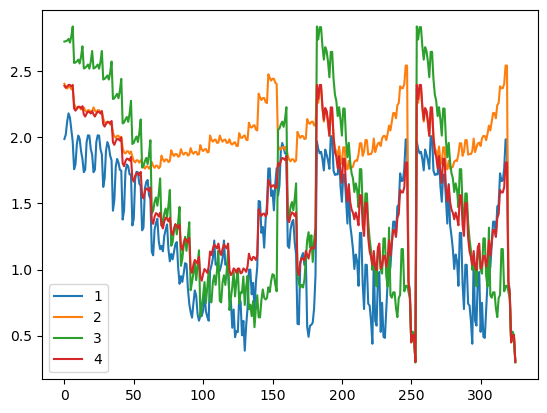

In [96]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dist[c0_i],axis=0),label='1')
plt.plot(np.average(dist[c1_i],axis=0),label='2')
plt.plot(np.average(dist[c2_i],axis=0),label='3')
plt.plot(np.average(dist[c3_i],axis=0),label='4')
plt.legend()
#plt.savefig("fasudil_clusters.png")

In [1]:
!pwd

/home/apara/Documents/asn/tica/lig_47/hbond


In [5]:
dtraj = np.load('/home/apara/Documents/asn/tica/lig_47/hbond/lig47_inter_hbond_combined_10.npy')

In [6]:
#make tick labels
ticklabs = "1,2,3,4".split(",")
#make custom set of colors for each state
nstates = dtraj.max()+1
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [7]:
#make instance of bayesian MSM  to estimate errors from bootstrapping (gibbs sampling)
lagtime = 10
bmsm = pyemma.msm.bayesian_markov_model(dtraj,lagtime,nsamples=10)    
ck = bmsm.cktest(nstates-1,memberships = np.eye(nstates),n_jobs=1,)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[0]: Sampling MSMs:   0%|                                       …

estimating BayesianMSM:   0%|                                                                                 …

In [8]:
#customize pyemma source code
def _add_ck_subplot(cktest, test_index, ax, i, j, ipos=None, jpos=None, y01=True, units='steps', dt=1., **plot_kwargs):
    # plot estimates
    for default in ['color', 'linestyle']:
        if default in plot_kwargs.keys():
            #print("ignoring plot_kwarg %s: %s"%(default, plot_kwargs[default]))
            plot_kwargs.pop(default)
    color = clist[1] ####this is added######

    lest = ax.plot(dt*cktest.lagtimes, cktest.estimates[:, i, j], color="black", **plot_kwargs)
    # plot error of estimates if available
    if cktest.has_errors and cktest.err_est:
        ax.fill_between(dt*cktest.lagtimes, cktest.estimates_conf[0][:, i, j], cktest.estimates_conf[1][:, i, j],
                        color='black', alpha=0.2)
    # plot predictions
    lpred = ax.plot(dt*cktest.lagtimes, cktest.predictions[:, i, j], color=color, linestyle='dashed', **plot_kwargs)
    # plot error of predictions if available
    if cktest.has_errors:
        ax.fill_between(dt*cktest.lagtimes, cktest.predictions_conf[0][:, i, j], cktest.predictions_conf[1][:, i, j],
                        color=color, alpha=0.2)
    # add label
    ax.text(0.1, 0.8, str(i+1)+' ->'+str(j+1), transform=ax.transAxes, weight='bold')
    if y01:
        ax.set_ylim(0, 1)
    # Axes labels
    if ipos is None:
        ipos = i
    if jpos is None:
        jpos = j
    if (jpos == 0):
        ax.set_ylabel('probability')
    if (ipos == cktest.nsets-1):
        ax.set_xlabel('lag time (' + units + ')')
    # return line objects
    return lest, lpred


def plot_cktest(cktest, figsize=None, diag=False,  y01=True, layout=None,
                padding_between=0.1, padding_top=0.075, units='steps', dt=1., **plot_kwargs):
    """Plot of Chapman-Kolmogorov test
    Parameters
    ----------
    cktest : msm.ChapmanKolmogorovValidator or list of msm.ChapmanKolmogorovValidator
        Chapman-Kolmogorov Test, optionally a list of tests which are all 
        plotted into the same set of axes. This assumes that all cktests were
        estimated for the same nstates.
    figsize : shape, default=(10, 10)
        Figure size
    diag : bool, default=False
        Plot only diagonal elements of the test, i.e. self-transition
        probabilities.
    y01 : bool, default=True
        Scale all y-Axes to [0,1]. If True, the y-Axes can be shared
        and the figure is tighter. If False, each y Axis will be scaled
        automatically.
    layout : str or shape or None, default=None
        Organization of subplots. You can specify your own shape. If None,
        an automatic shape will be selected. Use 'wide' for plots that
        span the page width (double-column figures) and 'tall' for
        single-column figures.
    padding_between : float, default=0.1
        padding space between subplots (as a fraction of 1.0)
    padding_top : float, default=0.05
        padding space on top of subplots (as a fraction of 1.0)
    **plot_kwargs : optional keyword arguments for the matplotlib.pylab.plot() call
        The user is allowed to choose values like marker='x', linewidth=3 etc. Note that
        'linestyle' and 'color' are defaults and cannot be changed using plot_kwargs
    Returns
    -------
    fig : Figure object
    axes : Axis objects with subplots
    """
    if not isinstance(cktest, (list, tuple)):
        cktests = [cktest]
    else:
        cktests = cktest
    cktest = cktests[0]
    for test in cktests:
        assert cktest.nsets == test.nsets, "cktests all need same number of sets"
    import matplotlib.pylab as plt
    sharey = y01
    # first fix subfigure layout
    if diag:
        if layout is None or layout == 'wide':
            ncol = min(4, cktest.nsets)
            layout = (int(math.ceil(cktest.nsets / ncol)), ncol)
        elif layout == 'tall':
            nrow = min(4, cktest.nsets)
            layout = (nrow, int(math.ceil(cktest.nsets / nrow)))
    else:
        layout = (cktest.nsets, cktest.nsets)
    # fix figure size
    if figsize is None:
        size_per_subplot = min(3.0, 10.0 / np.max(np.array(layout)))
        figsize = (size_per_subplot*layout[1], size_per_subplot*layout[0])
    # generate subplots
    fig, axes = plt.subplots(layout[0], layout[1], sharex=True, sharey=sharey, figsize=figsize)
    axeslist = list(axes.flatten())
    # line objects
    lest = None
    lpred = None
    # plot
    lests = []
    lpreds = []
    for test_index, test in enumerate(cktests):
        for (k, ax) in enumerate(axeslist):
            if diag and k < cktest.nsets:
                ipos = int(k/layout[1])
                jpos = int(k%layout[1])
                lest, lpred = _add_ck_subplot(test, test_index, ax, k, k, ipos=ipos, jpos=jpos, y01=y01, units=units,
                                              dt=dt, **plot_kwargs)
                k += 1
            else:
                i = int(k/cktest.nsets)
                j = int(k%cktest.nsets)
                lest, lpred = _add_ck_subplot(test, test_index, ax, i, j, y01=y01, units=units, dt=dt, **plot_kwargs)
        lests.append(lest[0])
        lpreds.append(lpred[0])
    # figure legend
    handles = []
    labels = []
    for ix, test in enumerate(cktests):
        predlabel = 'predict {}'.format(ix) if len(cktests) > 1 else 'predict'
        estlabel = 'estimate {}'.format(ix) if len(cktests) > 1 else 'estimate'
        if cktest.has_errors:
            predlabel += '     conf. {:3.1f}%'.format(100.0*cktest.conf)
        handles.append(lests[ix])
        handles.append(lpreds[ix])
        labels.append(predlabel)
        labels.append(estlabel)
    fig.legend(handles, labels, 'upper center', ncol=2, frameon=False,prop={'size': 15})
    # change subplot padding
    plt.subplots_adjust(top=1.0-padding_top, wspace=padding_between, hspace=padding_between)
    # done
    return fig, axes

Text(0.05, 0.5, 'Probability')

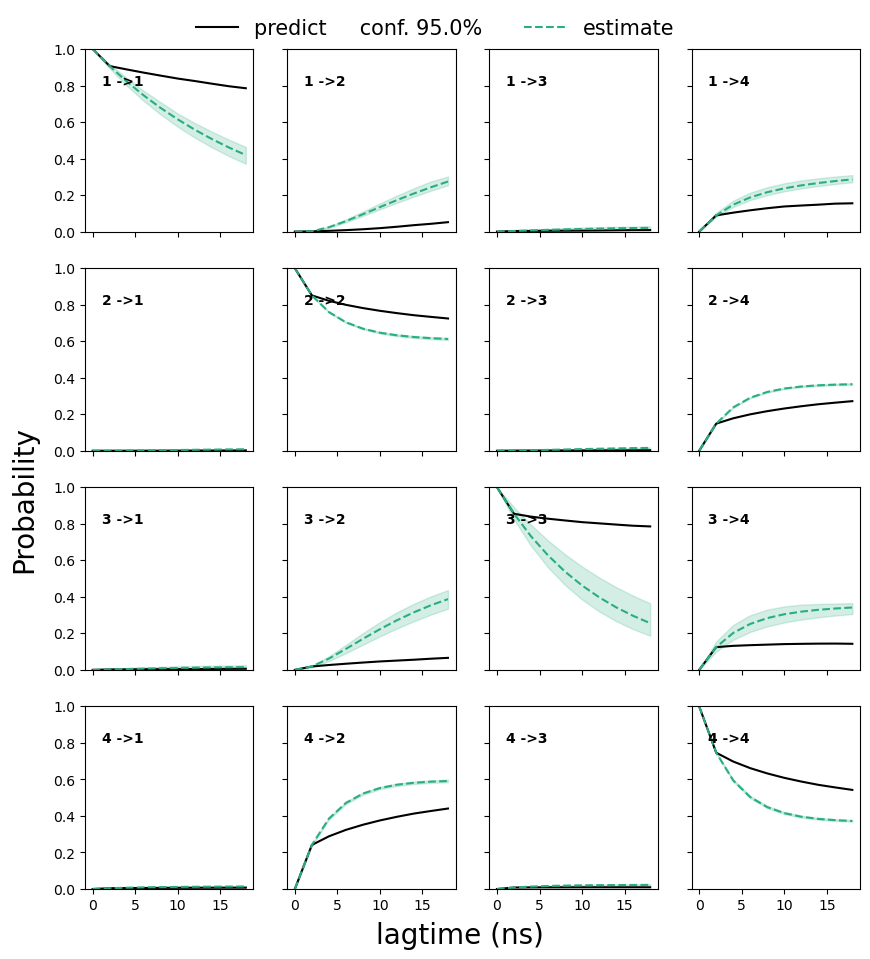

In [9]:
#plot customized CK plot
fig, ax =plot_cktest(ck,figsize=(10,10),padding_top= .05,units = "ns", dt = .2,
                                  padding_between = 0.2, y01=True,layout="wide")
for axi in ax.flat:
    axi.set_xlabel(None)
    axi.set_ylabel(None)
fig.supxlabel("lagtime (ns)",x=0.5,y=.05,size = 20)
fig.supylabel("Probability",x=.05,y=.5,size = 20)

In [10]:
#customize pyemma source code
from pyemma.util.statistics import confidence_interval as _conf
from pyemma.util.types import is_iterable_of_int as _is_iterable_of_int, is_int as _is_int
import numpy as _np
__author__ = 'noe'


def plot_implied_timescales(ITS, ax=None, outfile=None, show_mle=True, show_mean=True,
                            xlog=False, ylog=True, confidence=0.95, refs=None, nits=-1,
                            process=None, units='steps', dt=1., **kwargs):
    r"""Implied timescale plot
    Parameters
    ----------
    ITS : implied timescales object.
        Object whose data will be plotted. Should be of type :class:`ImpliedTimescales <pyemma.msm.ImpliedTimescales>`
        or a 3-tuple with: 1d array of lagtimes, (lagtimes, processes) array of timescales,
        optionally (lagtimes, processes, samples) array of timescales of samples.
    ax : matplotlib Axes object, optional, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    outfile : str, optional, default = None
        output file to write the figure to. When not given, the plot will be displayed
    show_mean : bool, default = True
        Line for mean value will be shown, if available
    show_mle : bool, default = True
        Line for maximum likelihood estimate will be shown
    xlog : bool, optional, default = False
        Iff true, the x-Axis is logarithmized
    ylog : bool, optional, default = True
        Iff true, the y-Axis is logarithmized
    confidence : float, optional, default = 0.95
        The confidence interval for plotting error bars (if available)
    refs : ndarray((m), dtype=float), optional, default = None
        Reference (exact solution or other reference) timescales if known. The number of timescales must match those
        in the ITS object
    nits: integer, default = -1
        Number of implied timescales to be shown. The default behaviour (-1) is to show all timescales available.
        :py:obj:`nits` != -1 and :py:obj:`process` != None are mutually exclusive
    process : iterable of integers, default is None
        list or ndarray((m), dtype=int) containing a list of the processes to be shown. The default behaviour is
        to show all timescales available.
        :py:obj:`process` != None and :py:obj:`nits` != -1 are mutually exclusive
    units: str or list (len=2) of strings, optional, default = 'steps'
        Affects the labeling of the axes. Used with :py:obj:`dt`, allows for changing the physical units of the axes.
        Accepts simple LaTeX math strings, eg. '$\mu$s'
        If this parameter is a list, it will be assumed that units[0] is for the x-axis and units[1] for the y-axis.
    dt: float or list(len=2) of floats, optional, default = 1.0
        Physical time between frames, expressed the units given in :py:obj:`units`. E.g, if you know that each
        frame corresponds to .010 ns, you can use the combination of parameters :py:obj:`dt` =0.01,
        :py:obj:`units` ='ns' to display the implied timescales in ns (instead of frames)
        If this parameter is a list, it will be assumed that dt[0] is for the x-axis and dt[1] for the y-axis.
    **kwargs: Will be passed to pyplot.plot when plotting the MLE datapoints (not the bootstrapped means).
            See the doc of pyplot for more options. Most useful lineproperties like `marker='o'` and/or :markersize=5
    Returns
    -------
    ax : Axes object containing the plot
    """
    if isinstance(ITS, tuple):
        assert len(ITS) in (2, 3)
        lags = _np.asarray(ITS[0])
        timescales = _np.asarray(ITS[1])
        timescales_samples = _np.asarray(ITS[2]) if len(ITS) == 3 and ITS[2] is not None else None
        n_timescales = timescales.shape[1]
        samples_available = timescales_samples is not None
    else:
        lags = ITS.lagtimes
        n_timescales = ITS.number_of_timescales
        timescales = ITS.get_timescales()
        samples_available = ITS.samples_available
        timescales_samples = ITS.timescales_samples
        if timescales_samples is not None:
            timescales_samples = timescales_samples.transpose(1, 2, 0)
    import matplotlib.pyplot as _plt
    # check input
    if ax is None:
        ax = _plt.gca(figsize= (10,6))
    colors = clist ######ADDED#####
    xmax = _np.max(lags)
    srt = _np.argsort(lags)
    # Check the processes to be shown
    if process is not None:
        if nits != -1:
            raise TypeError(
                'optional arguments nits and process are mutually exclusive:', nits, process)
        if not _is_iterable_of_int(process):
            raise ValueError('process has to be an iterable of integers')
        if _np.max(process)+1 > n_timescales:
            raise ValueError(
                'requested process %u, whereas ITS only contains %u timescales' % (
                    _np.max(process), n_timescales))
        # Now that it's for sure that nits==-1,
        # process is iter_of_ints, and the requested processes exist in its object:
        its_idx = process
    else:
        if not _is_int(nits):
            raise TypeError('nits is not an integer, ',nits)
        if nits == -1:
            nits = n_timescales
        its_idx = _np.arange(n_timescales)[:nits]
    # Check units and dt for user error.
    if isinstance(units, list) and len(units) != 2:
        raise TypeError("If units is a list, len(units) has to be = 2")
    if isinstance(dt, list) and len(dt) != 2:
        raise TypeError("If dt is a list, len(dt) has to be = 2")
    # Create list of units and dts for different axis
    if isinstance(units, str):
        units = [units] * 2
    if isinstance(dt, (float, int)):
        dt = [dt] * 2
    for i in its_idx:
        # plot estimate
        if show_mle:
            ax.plot(
                lags[srt] * dt[0], timescales[..., i][srt] * dt[1],
                color=colors[i % len(colors)], **kwargs)
        # sample available?
        if samples_available:
            # plot sample mean
            process_samples = timescales_samples[:, i, :].T
            if show_mean:
                sample_mean = _np.mean(process_samples, axis=0)
                ax.plot(
                    lags[srt] * dt[0], sample_mean[srt] * dt[1], marker='o',
                    color=colors[i % len(colors)], linestyle='dashed')
            lconf, rconf = _conf(process_samples, conf=confidence)
            ax.fill_between(
                lags[srt] * dt[0], lconf[srt] * dt[1], rconf[srt] * dt[1],
                alpha=0.2, color=colors[i % len(colors)])
        # reference available?
        if refs is not None:
            tref = refs[i] * dt[1]
            ax.plot([0, min(tref, xmax) * dt[0]], [tref, tref], color='black', linewidth=1)
    # cutoff
    ax.plot(lags[srt] * dt[0], lags[srt] * dt[1], linewidth=2, color='black')
    ax.set_xlim([1.0 * dt[0], xmax * dt[0]])
    ax.fill_between(
        lags[srt] * dt[0], ax.get_ylim()[0]*_np.ones(len(lags))*dt[1], lags[srt] * dt[1],
        alpha=0.2, color='grey')
    # formatting
    ax.set_xlabel('lag time / %s' % units[0])
    ax.set_ylabel('timescale / %s' % units[1])
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    # show or save
    if outfile is not None:
        _plt.savefig(outfile)
    return ax

estimating BayesianMSM:   0%|                                                                                 …

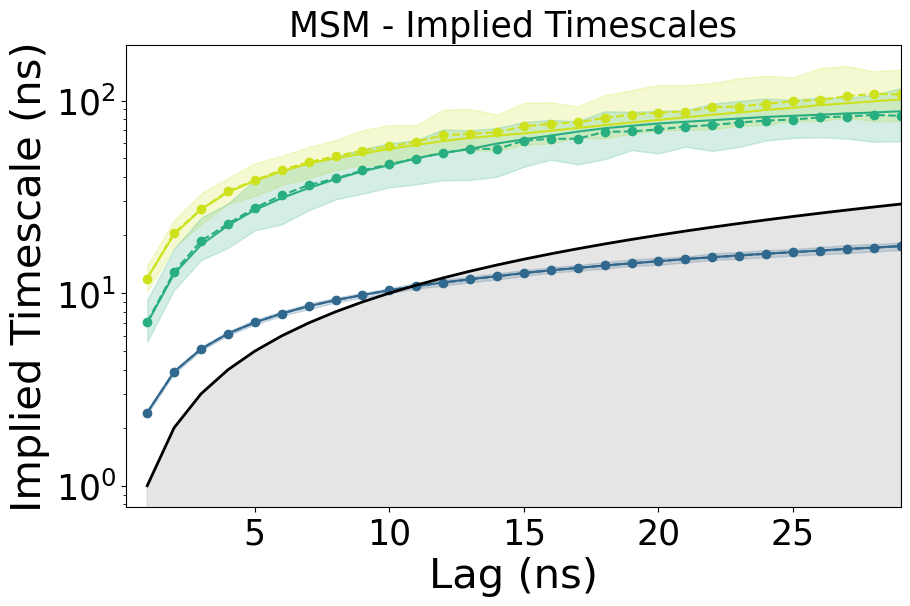

In [11]:
its = pyemma.msm.its(dtraj,np.arange(5,150,5),nits=nstates-1, errors="bayes", nsamples = 100,
                    n_jobs=1, )
fig,ax = plt.subplots(1,figsize=(10,6))
plot_implied_timescales(its,units="ns", dt=.2,ax=ax)
ax.set_xlabel("Lag (ns)",size=30)
ax.set_ylabel("Implied Timescale (ns)",size=30)
ax.set_title("MSM - Implied Timescales",size=25)
ax.tick_params("both", labelsize=25)

In [12]:
#stationary distribution errors
stat_error_l,stat_error_r = bmsm.sample_conf("stationary_distribution") #this estimate has the mean added to it
#above is a computation of the 95% confidence interval
stat_dist_mean = bmsm.sample_mean("stationary_distribution")
stat_dist_error = abs(np.stack([stat_error_l,stat_error_r]) - stat_dist_mean)

(0.5, 4.5)

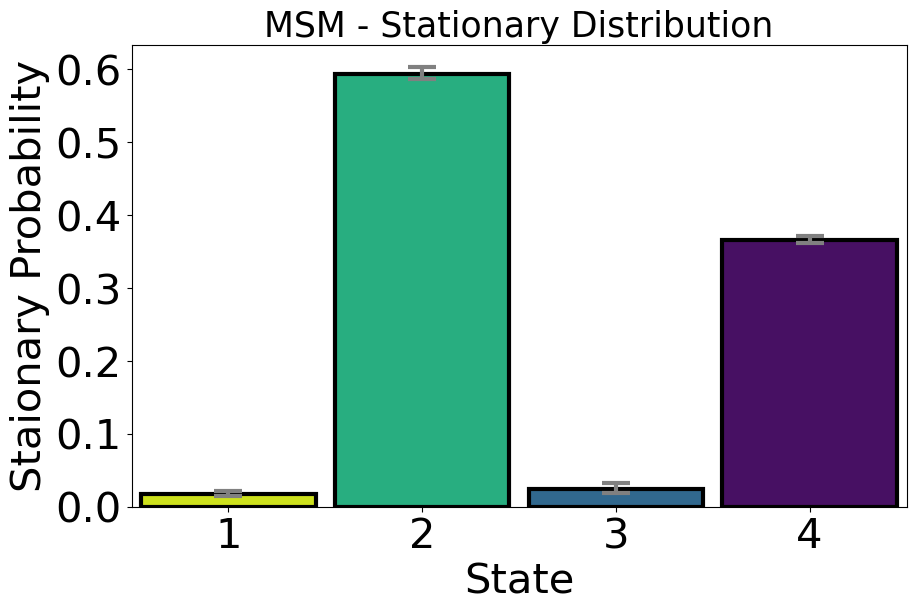

In [13]:
plt.figure(figsize = (10,6))
plt.bar(np.arange(1,nstates+1),stat_dist_mean,yerr = stat_dist_error,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))
plt.xticks(np.arange(1,nstates+1), ticklabs)
plt.xlabel("State", size=30)
plt.ylabel("Staionary Probability", size=30)
plt.title("MSM - Stationary Distribution",size=25)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.xlim(.5,nstates+.5)

In [14]:
def plot_mat_error(mat,emat,title,unit,cbarlabel,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = ax.imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                e = emat[j,i]
                ax.text(i, j,f"{np.round(c,1)}$\pm${np.round(e,2)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax.set_yticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_xticks(list(range(len(mat))), ticklabs,size=35)
        ax.set_ylabel(r"$State_{i}$", size=45)
        ax.set_xlabel(r"$State_{j}$", size=45)
        cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        cb.set_label(cbarlabel, size=40)
        cb.ax.tick_params(labelsize=30)
        ax.set_title(title, size = 45)
        plt.show()
        return

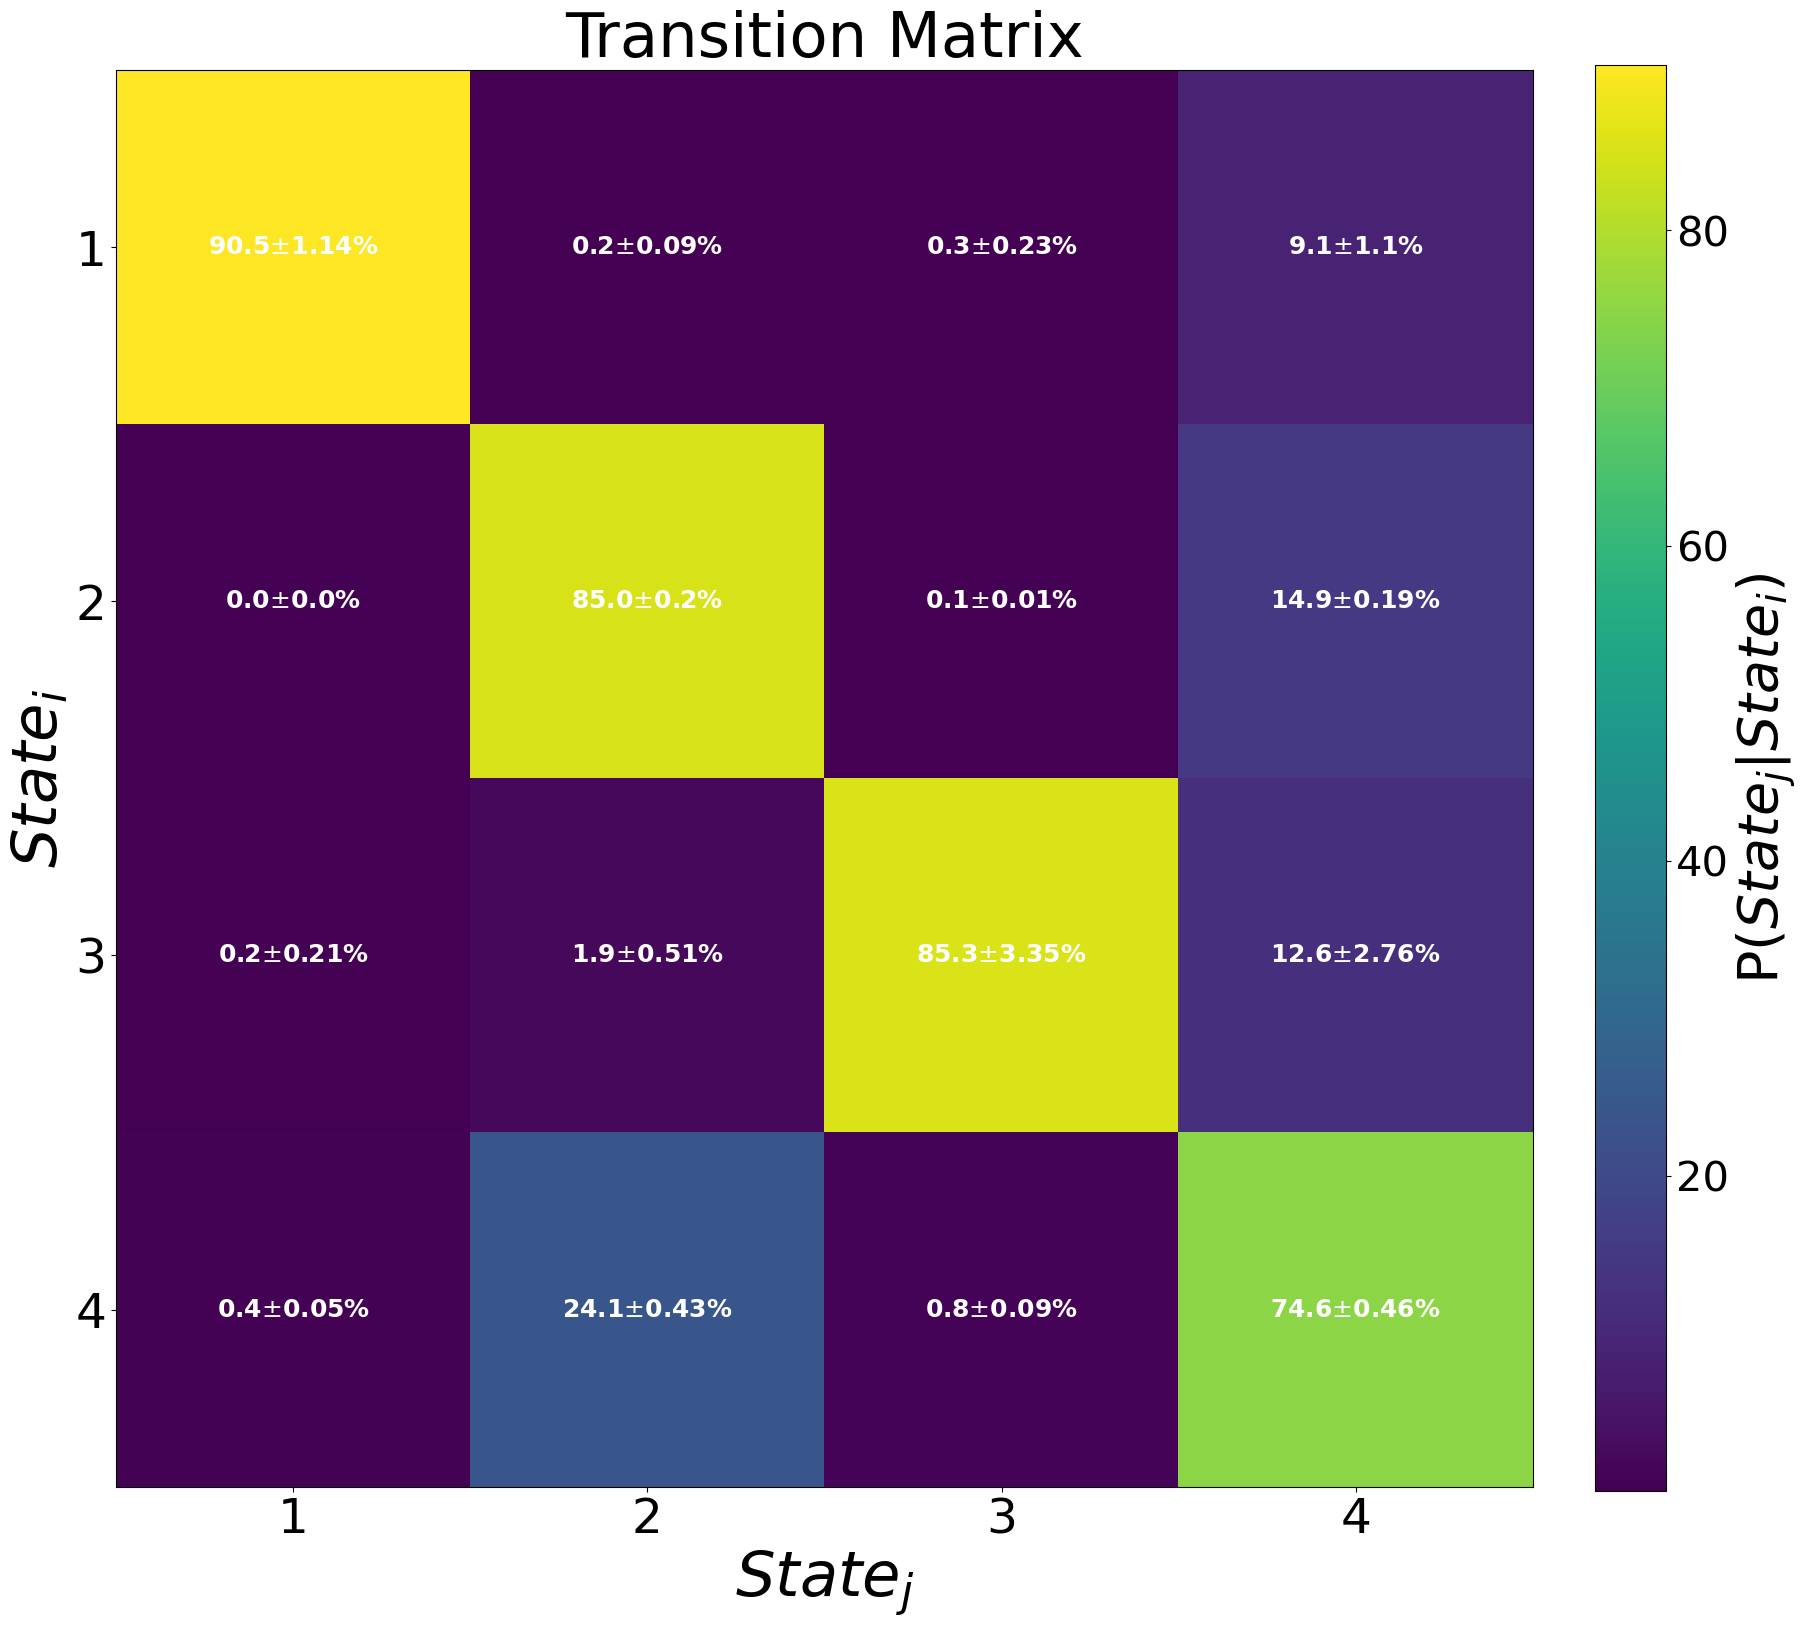

In [15]:
#transition matrix errors
tmat_l,tmat_r = bmsm.sample_conf("transition_matrix")
tmat = bmsm.sample_mean("transition_matrix")
rel_tmat_error = (abs(tmat-tmat_l)+abs(tmat-tmat_r))/2
tmat *= 100
rel_tmat_error *= 100

plot_mat_error(tmat,rel_tmat_error,"Transition Matrix","%",
               r"P($State_{j}$|$State_{i}$)",18,"white","viridis",ticklabs )

/home/apara/miniconda3/envs/pyemma/lib/python3.10/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


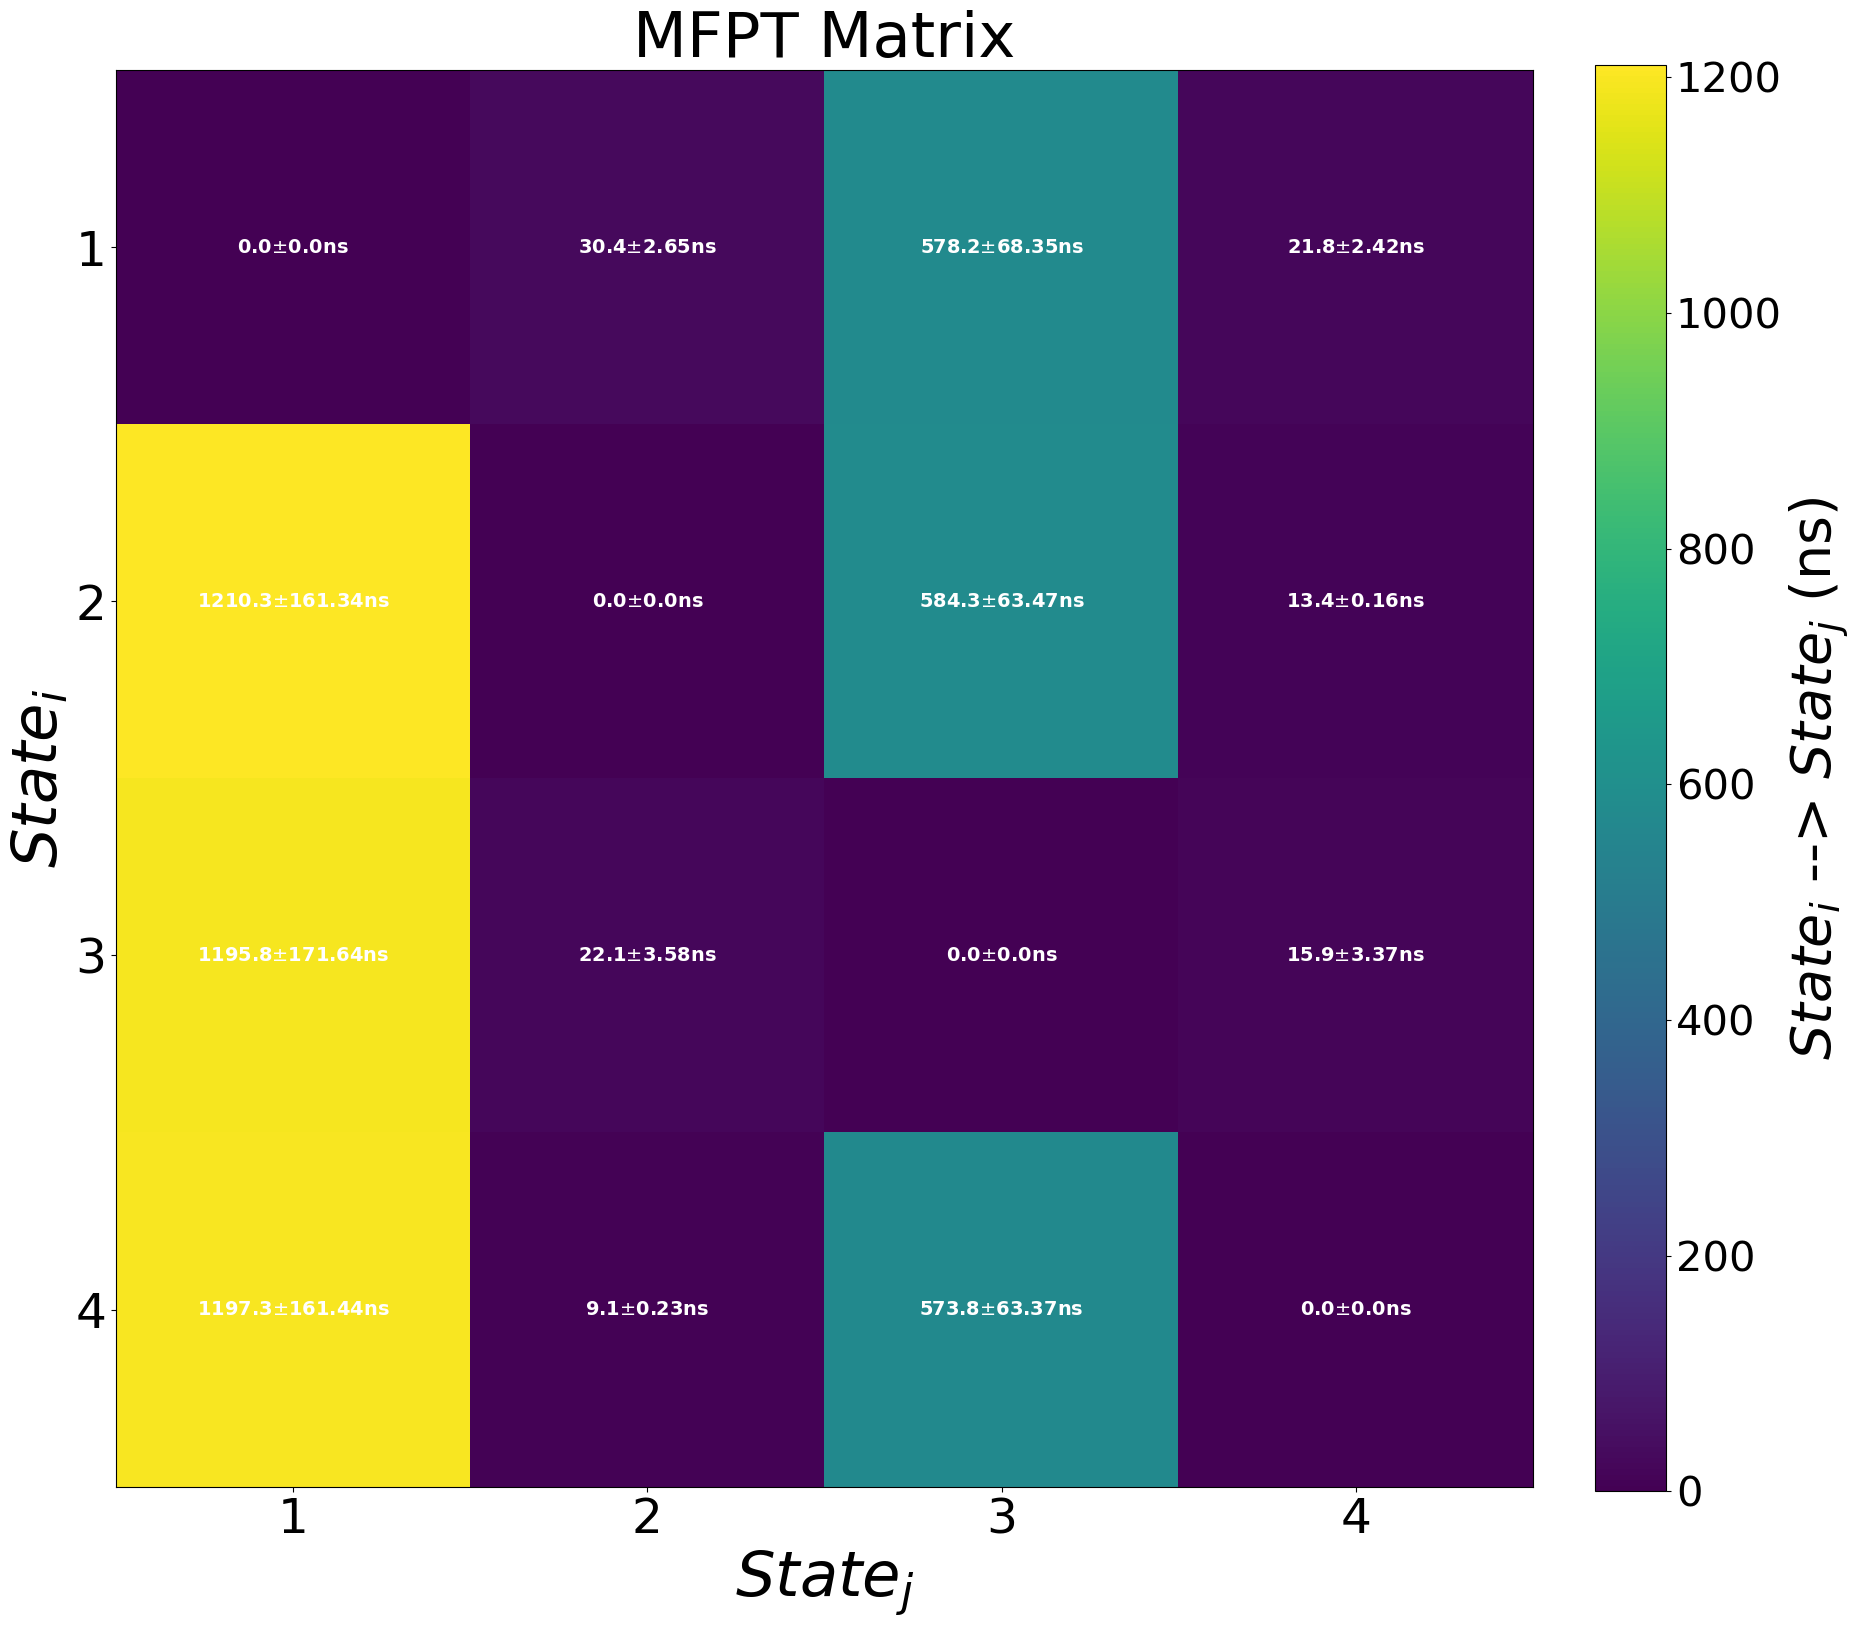

In [16]:
mfpt_error = np.zeros((nstates,nstates))
mfpt_mean = np.zeros((nstates,nstates))
for i in range(nstates):
    for j in range(nstates):
        mean = bmsm.sample_mean("mfpt", i,j)*(.2)
        mfpt_mean[i,j] = mean
        l,r = np.array(bmsm.sample_conf("mfpt", i,j))*(.2)
        mfpt_error[i,j] = (abs(mean-r)+abs(mean-l))/2
        
        
plot_mat_error(mfpt_mean,mfpt_error,"MFPT Matrix","ns",r"$State_{i}$ --> $State_{j}$ (ns)",
         14,"white","viridis",ticklabs)

[[0.001 0.000 0.001 ... 0.000 0.000 0.000]
 [0.000 0.000 0.001 ... 0.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 ...
 [0.001 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]]


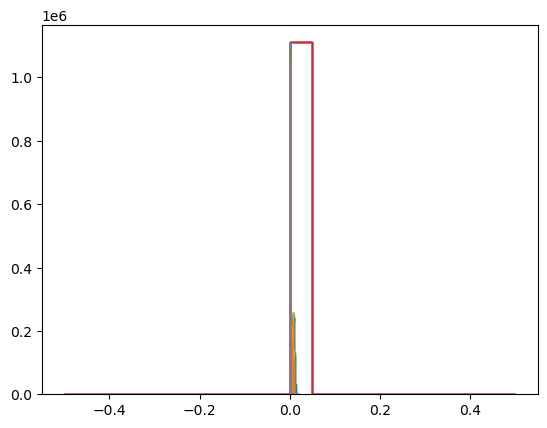

In [89]:
#dists = np.arange(0, 10, 0.1)
def sigmoid(x):
    z = np.exp((-4*x+4))
    sig = 1- 1 / (1 + z)
    return sig

dmat_sig=sigmoid(dmat)

for i in range(0,1988):
   plt.hist((dmat_sig[:,i]),histtype='step',bins=20,label=i) 

print (dmat_sig)

ValueError: x and y must be the same size

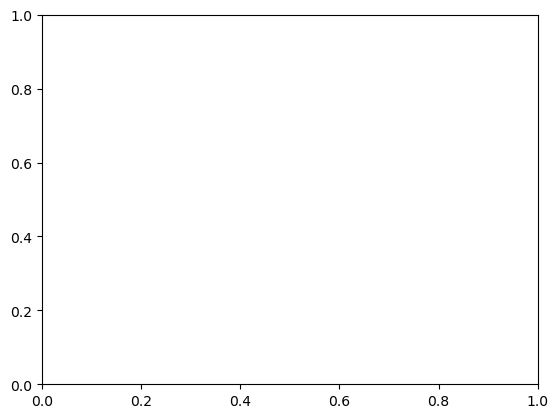

In [28]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 1
##
combined = dmat_sig
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


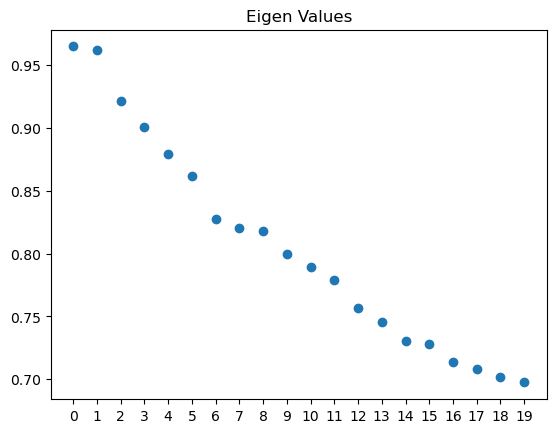

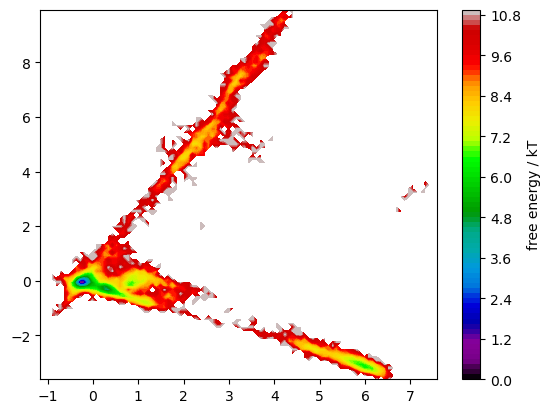

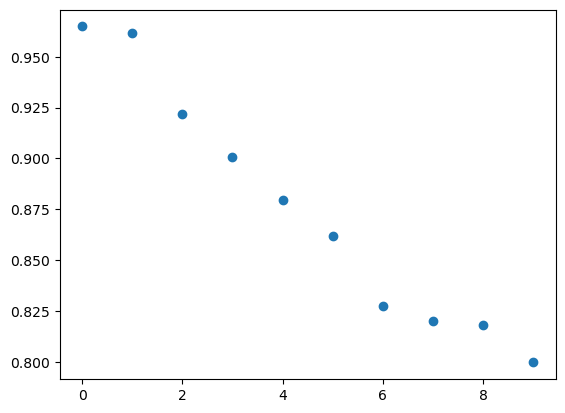

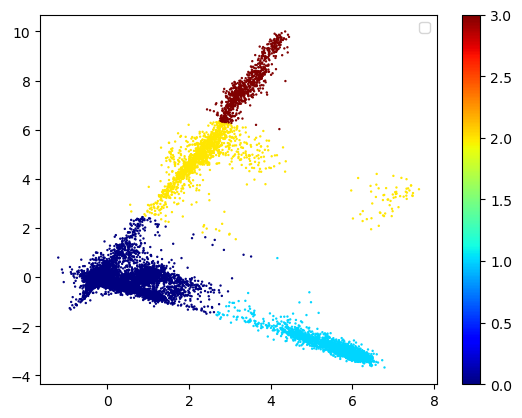

In [42]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 10
##
combined = hbonds_f
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5,cmap = "jet")
plt.colorbar()
plt.legend()

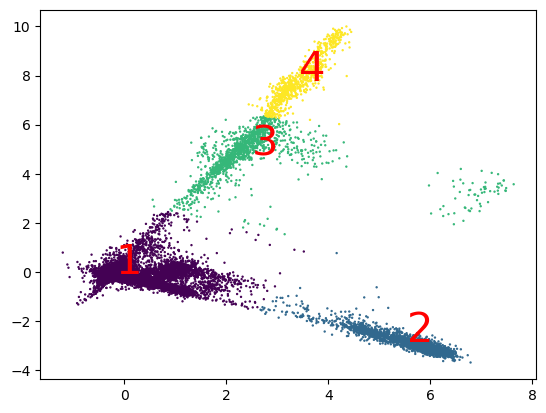

In [43]:
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
for j,i in enumerate(clustercenters):
    plt.annotate(f"{j+1}", [i[k] for k in range(2)], color="red", size="30")

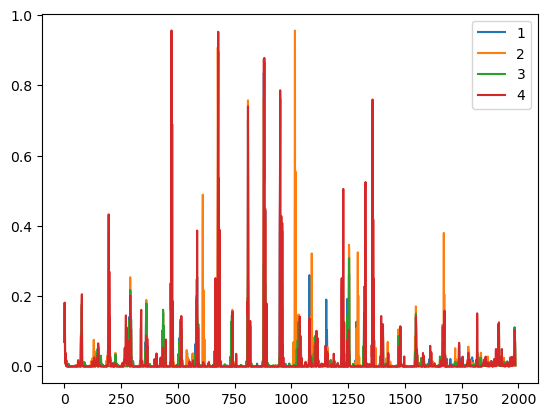

In [32]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(hbonds_f[c0_i],axis=0),label='1')
plt.plot(np.average(hbonds_f[c1_i],axis=0),label='2')
plt.plot(np.average(hbonds_f[c2_i],axis=0),label='3')
plt.plot(np.average(hbonds_f[c3_i],axis=0),label='4')
plt.legend()

In [98]:
trj[frames_cl[0]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hbond/lig47_hbond_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hbond/lig47_hbond_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hbond/lig47_hbond_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/home/apara/Documents/asn/tica/lig_47/hbond/lig47_hbond_cluster_4.dcd") #save frames